In [1]:
%matplotlib inline
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import raw_process

In [3]:
raw = raw_process.read("sample2.ARW")

In [4]:
raw_array = raw_process.get_raw_array(raw)
blc_raw = raw_process.black_level_correction(raw, raw_array)

In [5]:
bayer_pattern = raw.raw_pattern
print(bayer_pattern)

[[0 1]
 [3 2]]


In [6]:
h, w = blc_raw.shape

In [7]:
import numpy as np

In [28]:
bayer_img = np.zeros((h, w, 3))
bayer_pattern[bayer_pattern == 3] = 1
gain = [2, 1, 2]
for y in range(0, h):
    for x in range(0, w):
        color = bayer_pattern[y % 2, x % 2]
        bayer_img[y, x, color] = gain[color] * blc_raw[y, x]

In [9]:
from matplotlib.pyplot import imshow

In [10]:
print(raw.camera_whitebalance)

[1668.0, 1024.0, 2360.0, 1024.0]


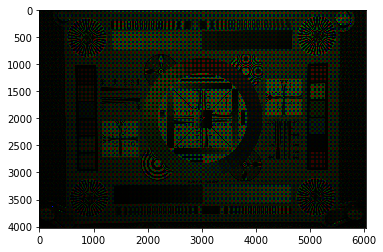

In [29]:
outimg = bayer_img.copy()
outimg[outimg < 0] = 0
outimg = outimg / outimg.max() * 4
outimg[outimg > 1.0] = 1.0
imshow(outimg)

In [12]:
import imageio
outimg = bayer_img.copy()
outimg[outimg < 0] = 0
outimg = outimg / outimg.max() * 255 * 8
outimg[outimg > 255] = 255
imageio.imwrite("bayer.png", outimg.astype('uint8'))

In [13]:
def mirror(x, min, max):
    if x < min:
        return min - x
    elif x >= max:
        return 2 * max - x - 2
    else:
        return x

In [14]:
dms_img = np.zeros((h, w, 3))
bayer_pattern = raw.raw_pattern
for y in range(0, h):
    for x in range(0, w):
        color = bayer_pattern[y % 2, x % 2]
        y0 = mirror(y-1, 0, h)
        y1 = mirror(y+1, 0, h)
        x0 = mirror(x-1, 0, w)
        x1 = mirror(x+1, 0, w)
        if color == 0:
            dms_img[y, x, 0] = blc_raw[y, x]
            dms_img[y, x, 1] = (blc_raw[y0, x] + blc_raw[y, x0] + blc_raw[y, x1] + blc_raw[y1, x])/4
            dms_img[y, x, 2] = (blc_raw[y0, x0] + blc_raw[y0, x1] + blc_raw[y1, x0] + blc_raw[y1, x1])/4
        elif color == 1:
            dms_img[y, x, 0] = (blc_raw[y, x0] + blc_raw[y, x1]) / 2
            dms_img[y, x, 1] = blc_raw[y, x]
            dms_img[y, x, 2] = (blc_raw[y0, x] + blc_raw[y1, x]) / 2
        elif color == 2:
            dms_img[y, x, 0] = (blc_raw[y0, x0] + blc_raw[y0, x1] + blc_raw[y1, x0] + blc_raw[y1, x1])/4
            dms_img[y, x, 1] = (blc_raw[y0, x] + blc_raw[y, x0] + blc_raw[y, x1] + blc_raw[y1, x])/4
            dms_img[y, x, 2] = blc_raw[y, x]
        else:
            dms_img[y, x, 0] = (blc_raw[y0, x] + blc_raw[y1, x]) / 2
            dms_img[y, x, 1] = blc_raw[y, x]
            dms_img[y, x, 2] = (blc_raw[y, x0] + blc_raw[y, x1]) / 2

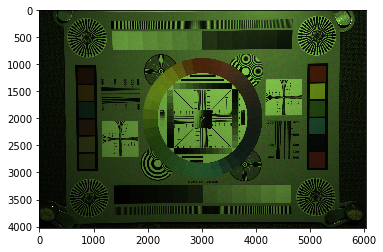

In [27]:
outimg = dms_img.copy()
outimg[outimg < 0] = 0
outimg = outimg / outimg.max() * 4
outimg[outimg > 1] = 1
imshow(outimg)

In [16]:
img_wb = raw_process.white_balance(raw, dms_img)
color_matrix = [1141, -205, 88, -52, 1229, -154, 70, -225, 1179]
img_ccm = raw_process.color_correction_matrix(img_wb, color_matrix)
rgb_image = raw_process.gamma_correction(img_ccm)

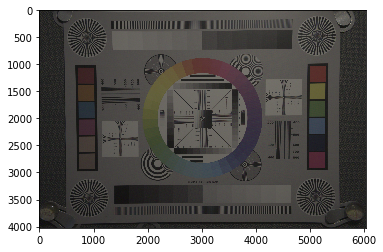

In [17]:
outimg = rgb_image.copy()
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)

In [18]:
raw_process.write(rgb_image, "output3.png")

In [19]:
from scipy import signal

blc_green = blc_raw.copy()
blc_green[(raw.raw_colors == 0) | (raw.raw_colors == 2)] = 0
g_flt = np.array([[0, 1/4, 0], [1/4, 1, 1/4], [0, 1/4, 0]])
green = signal.convolve2d(blc_green, g_flt, boundary='symm', mode='same')

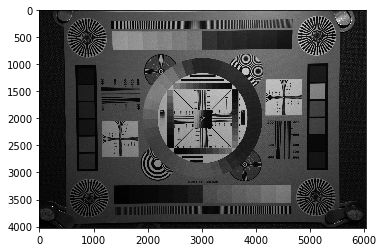

In [20]:
outimg = green.copy()
outimg[outimg < 0] = 0
outimg = outimg / outimg.max() * 4
outimg[outimg > 1] = 1
imshow(outimg, cmap='gray')

In [21]:
blc_red = blc_raw.copy()
blc_red[raw.raw_colors != 0] = 0
rb_flt = np.array([[1/4, 1/2, 1/4], [1/2, 1, 1/2], [1/4, 1/2, 1/4]])
red = signal.convolve2d(blc_red, rb_flt, boundary='symm', mode='same')

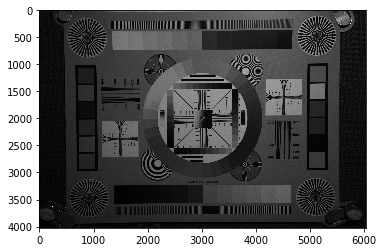

In [22]:
outimg = red.copy()
outimg[outimg < 0] = 0
outimg = outimg / outimg.max() * 4
outimg[outimg > 1] = 1
imshow(outimg, cmap='gray')

In [23]:
dms_img2 = np.zeros((h, w, 3))

blc_green = blc_raw.copy()
blc_green[(raw.raw_colors == 0) | (raw.raw_colors == 2)] = 0
g_flt = np.array([[0, 1/4, 0], [1/4, 1, 1/4], [0, 1/4, 0]])
dms_img2[:, :, 1] = signal.convolve2d(blc_green, g_flt, boundary='symm', mode='same')

blc_red = blc_raw.copy()
blc_red[raw.raw_colors != 0] = 0
rb_flt = np.array([[1/4, 1/2, 1/4], [1/2, 1, 1/2], [1/4, 1/2, 1/4]])
dms_img2[:, :, 0] =  signal.convolve2d(blc_red, rb_flt, boundary='symm', mode='same')

blc_blue = blc_raw.copy()
blc_blue[raw.raw_colors != 2] = 0
rb_flt = np.array([[1/4, 1/2, 1/4], [1/2, 1, 1/2], [1/4, 1/2, 1/4]])
dms_img2[:, :, 2] =  signal.convolve2d(blc_blue, rb_flt, boundary='symm', mode='same')

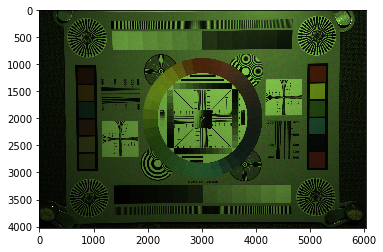

In [24]:
outimg = dms_img2.copy()
outimg[outimg < 0] = 0
outimg = outimg / outimg.max() * 4
outimg[outimg > 1] = 1
imshow(outimg)

In [25]:
img_wb = raw_process.white_balance(raw, dms_img2)
color_matrix = [1141, -205, 88, -52, 1229, -154, 70, -225, 1179]
img_ccm = raw_process.color_correction_matrix(img_wb, color_matrix)
rgb_image = raw_process.gamma_correction(img_ccm)

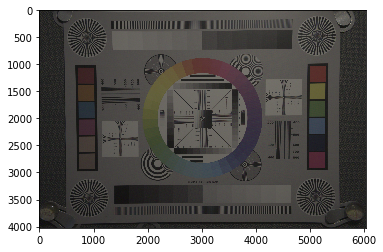

In [26]:
outimg = rgb_image.copy()
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)